##  Síntese de Holograma – Polarização X (Gerchberg–Saxton + ASM)
## Hologram Synthesis – X Polarization (Gerchberg–Saxton + ASM)

---

### Objetivo (PT)  
Este notebook demonstra a síntese de hologramas para **polarização X** utilizando o **algoritmo de Gerchberg–Saxton (GS)** combinado com o **Método do Espectro Angular (ASM)** para propagação óptica. O fluxo segue o pipeline descrito em **Guo et al. (2025)**, ajustando parâmetros ópticos e registrando as métricas de convergência.  

###  Objective (EN)  
This notebook demonstrates **hologram synthesis** for **X polarization** using the **Gerchberg–Saxton (GS)** algorithm combined with the **Angular Spectrum Method (ASM)** for optical propagation. The workflow follows the computational pipeline described in **Guo et al. (2025)**, allowing adjustable optical parameters and tracking convergence metrics.

---


### 💾 Saídas / Outputs
| Tipo | Descrição | Local |
|------|------------|--------|
| 🌀 Mapa de fase (`.txt`) | Fase final da máscara holográfica | `results/holography/gs_x/<experimento>/<run_id>/<alvo>/phase_map__*.txt` |
| 📈 Curva de correlação (`.csv`/`.txt`) | Correlação de Pearson por iteração | `results/holography/gs_x/<experimento>/<run_id>/<alvo>/correlations__*.txt` |
| 🖼️ Figura (`.png`) | Imagem alvo, mapa de fase, reconstrução, curva de convergência | `results/holography/gs_x/<experimento>/<run_id>/summary__*.png` |

---

### 1. 🔧 Imports

**PT** — Nesta seção importamos bibliotecas essenciais:
- `numpy` para operações numéricas e matrizes,
- `matplotlib.pyplot` para visualização,
- `scipy.fft` (fft2/ifft2, fftshift/ifftshift) para transformadas de Fourier 2D,
- `PIL.Image` para carregar e converter imagens.

**EN** — We import core libraries:
- `numpy` for numerical arrays,
- `matplotlib.pyplot` for plotting,
- `scipy.fft` (fft2/ifft2, fftshift/ifftshift) for 2D Fourier transforms,
- `PIL.Image` to load and convert images.


In [2]:
# =============================================================================
# PT: Importações principais para processamento numérico, FFT 2D e imagens
# EN: Main imports for numerical processing, 2D FFT, and image I/O
# =============================================================================
import numpy as np                      # PT: computação numérica | EN: numerical computing
import matplotlib.pyplot as plt         # PT/EN: plotting and visualization

# PT: FFT 2D e utilitários de shift no domínio da frequência
# EN: 2D FFT and frequency-domain shifting utilities
from scipy.fft import fft2, ifft2, fftshift, ifftshift

# PT: Carregamento e conversão de imagens (grayscale)
# EN: Image loading and conversion (grayscale)
from PIL import Image


### 2. ⚙️ Parâmetros Ópticos e de Execução | Optical and Execution Parameters

---

#### **PT - Descrição**  
Os parâmetros abaixo definem a geometria da propagação e o comportamento do algoritmo de Gerchberg–Saxton (GS), todos eles foram escolhidos de acordo com **Guo et al. (2025)** (com exceção de `num_iter`):

| Parâmetro | Significado | Exemplo |
|------------|-------------|---------|
| `λ` (*wavelength_m*) | Comprimento de onda (em metros) | 1064e-9 |
| `z_m` | Distância entre plano da máscara e plano da imagem | 380e-6 |
| `dx_m` | Passo de amostragem espacial no plano da máscara | 520e-9 |
| `NA` | Abertura numérica da lente equivalente | 0.65 |
| `num_iter` | Número de iterações GS | 200 |

As imagens alvo são carregadas em escala de cinza e normalizadas para amplitude [0, 1].

<details>
<summary><b>Show English</b></summary>

#### **EN - Description**  
The parameters below define the propagation geometry and the behavior of the **Gerchberg–Saxton** (GS) algorithm, all of them were chosen according to **Guo et al. (2025)** (except for `num_iter`):

| Parameter | Meaning | Example |
|------------|----------|---------|
| `λ` (*wavelength_m*) | Wavelength (in meters) | 1064e-9 |
| `z_m` | Distance between mask and image plane | 380e-6 |
| `dx_m` | Spatial sampling pitch at mask plane | 520e-9 |
| `NA` | Numerical aperture of equivalent lens | 0.65 |
| `num_iter` | Number of GS iterations | 200 |

The target images are loaded in grayscale and normalized to amplitude range [0, 1].

</details>

---


In [1]:
# =============================================================================
# PT: Parâmetros do experimento (edite conforme seu setup/relatórios)
# EN: Experiment parameters (edit according to your setup/reports)
# =============================================================================
wavelength = 1064e-9     # EN: wavelength [m] | PT: comprimento de onda (m)
z = 380e-6               # EN: propagation distance [m] | PT: distância de propagação (m)
dx = 520e-9              # EN: sampling pitch at mask plane [m/pixel] | PT: passo de amostragem
NA = 0.65                # EN: numerical aperture | PT: abertura numérica
num_iter = 200           # EN: GS iterations | PT: número de iterações do GS


### 3. Carregamento e Pré-Processamento da Imagem Alvo | Loading and Pre-processing of the Target Image
Esta etapa prepara a **imagem alvo** para o algoritmo GS+ASM. O objetivo é padronizar o formato para garantir **amostragem consistente** e **estabilidade numérica** nas iterações:

- **Escala de cinza**: reduz o problema à **amplitude** (intensidade), como assumido no GS clássico para hologramas de fase única.
- **Redimensionamento fixo**: ajusta a imagem para uma **resolução de trabalho** compatível com o passo espacial (`dx`) e o tamanho que usaremos após o *zero-padding*.
- **Normalização para [0, 1]**: evita desbalancear as restrições de amplitude no plano da imagem e melhora a **convergência** do GS.

> Observação: se a imagem não for encontrada, é gerado um **padrão sintético simples** (só para testes), de modo que o notebook sempre rode e permita inspecionar a pipeline.

<details>
<summary><b>Show English</b></summary>

This step prepares the **target image** for the GS+ASM algorithm. We standardize the input to ensure **consistent sampling** and **numerical stability** during iterations:

- **Grayscale**: reduces the problem to **amplitude** (intensity), as assumed by classical GS for single-phase holograms.
- **Fixed resize**: sets a **working resolution** consistent with the spatial pitch (`dx`) and the array size we will use after zero-padding.
- **Normalization to [0, 1]**: prevents amplitude constraints from being ill-scaled and improves GS **convergence**.

> Note: if the image is not found, a **simple synthetic pattern** (for testing) is generated so the notebook always runs and the pipeline can be inspected.

</details>


In [3]:
def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    EN:
        Load and pre-process the target image using PIL.
        - Convert to grayscale
        - Resize to `target_size` (working resolution)
        - Convert to numpy array and normalize to [0, 1]

    PT:
        Carrega e pré-processa a imagem alvo usando PIL:
        - Converte para escala de cinza
        - Redimensiona para `target_size` (resolução de trabalho)
        - Converte para array numpy e normaliza em [0, 1]

    Parameters
    ----------
    image_path : str
        Path to the input image.
    target_size : tuple(int, int)
        Working resolution (width, height) used by the pipeline.

    Returns
    -------
    np.ndarray (float64)
        Normalized image array in [0, 1].
    """
    try:
        # EN: Load from disk and convert to grayscale (amplitude-only target)
        # PT: Carrega do disco e converte para escala de cinza (alvo de amplitude)
        image = Image.open(image_path).convert('L')

        # EN: Resize to a fixed working resolution; LANCZOS preserves edges for diffraction tasks
        # PT: Redimensiona para a resolução de trabalho; LANCZOS preserva bordas (útil em difração)
        image = image.resize(target_size, Image.LANCZOS)

        # EN: Convert to float64 array and normalize to [0, 1]
        # PT: Converte para float64 e normaliza em [0, 1]
        image_array = np.array(image, dtype=np.float64)
        max_val = np.max(image_array) if np.max(image_array) > 0 else 1.0  # avoid division by zero
        image_array = image_array / max_val

        return image_array

    except FileNotFoundError:
        # EN/PT: Educational fallback — create a simple synthetic logo-like test pattern
        print("Target image not found. Creating a simple synthetic logo-like pattern for testing...")
        w, h = target_size
        target_image = np.zeros((h, w), dtype=np.float64)

        # Simple block shapes: a vertical bar + two horizontal bars (generic emblem-like pattern)
        vbar_w = max(1, w // 9)
        target_image[h//3: 2*h//3, w//6: w//6 + vbar_w] = 1.0   # vertical bar
        target_image[h//3: h//3 + vbar_w, w//6: 5*w//6] = 1.0   # top horizontal
        target_image[2*h//3 - vbar_w: 2*h//3, w//6: 5*w//6] = 1.0  # bottom horizontal

        return target_image


### 4. Zero-padding da imagem | Zero-padding of the image

**PT** — Aplicamos *zero-padding* para embutir a imagem em uma matriz maior. Isso:
- aumenta a resolução no domínio de Fourier,
- reduz *aliasing* durante FFTs e propagação,
- segue a prática recomendada no artigo base para melhorar a reconstrução.

**Trade-off**: custo maior de memória/tempo.

<details>
<summary><b>Show English</b></summary>

We apply zero-padding to embed the image in a larger array. This:
- increases spectral sampling,
- reduces aliasing during FFTs/propagation,
- follows best practices from the reference paper to improve reconstruction.

**Trade-off**: higher memory/runtime.

</details>


In [4]:
def apply_zero_padding(image, padding_factor=2):
    """
    EN:
        Apply zero-padding around the input image.
        - Center the original image into a larger complex-valued array.
    PT:
        Aplica zero-padding ao redor da imagem de entrada.
        - Centraliza a imagem original em uma matriz maior (valores complexos).
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    # Center original image inside the padded array
    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size


### 5. Filtro Passa-Baixa (Abertura Numérica) | Low-Pass (LP) Filter (Numerical Aperture)

**PT — Explicação Física e Implementação**

A lente objetiva (ou o sistema óptico equivalente) **não transmite todas as frequências espaciais** do campo holográfico.  
De acordo com **Guo et al. (2025)**, apenas os componentes que satisfazem a condição:


$$ f_x^2 + f_y^2 \le \left(\frac{NA}{\lambda}\right)^2 $$

são propagáveis.  
Frequências maiores correspondem a **componentes evanescentes**, que decaem exponencialmente e **não contribuem** para a reconstrução no plano de imagem.  

A função abaixo cria uma **máscara circular binária** no domínio da frequência — 1 dentro do raio de corte e 0 fora — representando o **limite imposto pela abertura numérica (NA)**.  
Isso atua como um **filtro passa-baixa**, suprimindo as componentes que o sistema não consegue capturar.

> 💡 Esse filtro é aplicado diretamente no domínio de Fourier durante a propagação por Espectro Angular (ASM).

---

<details>
<summary><b>Show English</b></summary>

**EN — Physical Meaning and Implementation**

The objective lens (or equivalent optical system) does **not transmit all spatial frequencies** of the holographic field.  
According to **Guo et al. (2025)**, only components satisfying


$$ f_x^2 + f_y^2 \le \left(\frac{NA}{\lambda}\right)^2 $$

can propagate.  
Higher frequencies correspond to **evanescent components**, which decay exponentially and **do not contribute** to the image reconstruction.  

The function below creates a **binary circular mask** in the frequency domain — 1 inside the cutoff radius, 0 outside — representing the **numerical aperture (NA)** limit of the system.  
This effectively acts as a **low-pass filter**, suppressing unphysical or non-propagating components.

> 💡 The mask is applied directly in the Fourier domain during Angular Spectrum propagation (ASM).

</details>


In [5]:
def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    EN:
        Create a circular low-pass filter mask in the frequency domain,
        representing the system's numerical aperture limit.
        Frequencies satisfying (fx^2 + fy^2) > (NA/λ)^2 are cut off
        (non-propagating / evanescent components).

    PT:
        Cria uma máscara circular passa-baixa no domínio da frequência,
        representando o limite imposto pela abertura numérica (NA).
        Frequências que satisfazem (fx^2 + fy^2) > (NA/λ)^2 são cortadas
        (componentes não propagantes / evanescentes).
    """
    nx, ny = shape

    # EN: Build spatial frequency axes (1/m)
    # PT: Eixos de frequência espacial (ciclos por metro)
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)

    # EN/PT: 2D frequency grid
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    # EN/PT: Numerical aperture cutoff frequency (1/m)
    f_cutoff = NA / wavelength

    # EN/PT: Radial spatial frequency distribution
    freq_radius = np.sqrt(FX**2 + FY**2)

    # EN/PT: Circular low-pass mask: 1 inside, 0 outside
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask


### 6. Propagação por Espectro Angular (ASM) | Angular Spectrum Propagation (ASM)

**PT — Conceito e Motivação**

O método do **Espectro Angular (ASM)** é uma formulação rigorosa da propagação óptica baseada na decomposição espectral do campo.  
Qualquer campo complexo $ U(x, y) $ pode ser expresso como uma soma de **ondas planas** com frequências espaciais $ f_x, f_y $.  
Cada uma dessas ondas sofre apenas uma **mudança de fase** ao se propagar por uma distância $z$:


$$ H(f_x, f_y) = e^{\, i\, k\, z\, \sqrt{1 - (\lambda f_x)^2 - (\lambda f_y)^2}} $$


A multiplicação espectral por $ H(f_x, f_y) $ corresponde à propagação do campo.

- Quando $ 1 - (\lambda f_x)^2 - (\lambda f_y)^2 > 0 $, a onda é **propagante**.  
- Quando esse termo é negativo, temos uma **onda evanescente**, que decai exponencialmente e não chega ao plano de observação.

O ASM é amplamente usado em holografia computacional e simulações de metassuperfícies por ser **exato no regime de campo próximo** e numericamente eficiente via FFTs.

---

<details>
<summary><b>Show English</b></summary>

**EN — Concept and Motivation**

The **Angular Spectrum Method (ASM)** is a rigorous model of optical propagation based on the spectral decomposition of a complex field.  
Any field $ U(x, y) $ can be represented as a sum of **plane waves** with spatial frequencies $ f_x, f_y $.  
Each wave accumulates a **phase shift** upon propagation over a distance $ z $:


$$ H(f_x, f_y) = e^{\, i\, k\, z\, \sqrt{1 - (\lambda f_x)^2 - (\lambda f_y)^2}} $$


Multiplying the Fourier transform of the field by \( H(f_x, f_y) \) performs the propagation.

- If $ 1 - (\lambda f_x)^2 - (\lambda f_y)^2 > 0 $, the component is **propagating**.  
- If the term is negative, it represents an **evanescent wave**, which decays exponentially with $ z $.

ASM is widely used in computational holography and metasurface simulations because it is **accurate in the near field** and computationally efficient via FFTs.

</details>


In [6]:
def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    EN:
        Propagate the complex field U(x,y) by distance z using the Angular Spectrum Method.
        - Decompose field into spatial frequencies (fx, fy)
        - Multiply by propagation kernel H(fx, fy)
        - Apply optional low-pass filter (numerical aperture)
        - Reconstruct propagated field via inverse FFT

        Evanescent components (where root_term < 0) are suppressed, as they decay exponentially.

    PT:
        Propaga o campo complexo U(x,y) por uma distância z usando o Método do Espectro Angular (ASM).
        - Decompõe o campo em frequências espaciais (fx, fy)
        - Multiplica pelo kernel de propagação H(fx, fy)
        - Aplica filtro passa-baixa (NA) opcional
        - Reconstrói o campo propagado por transformada inversa de Fourier

        Componentes evanescentes (root_term < 0) são suprimidos, pois decaem exponencialmente.
    """
    # EN/PT: Wavenumber (2π/λ)
    k = 2 * np.pi / wavelength

    # EN/PT: Dimensions of the field
    nx, ny = U.shape

    # EN/PT: Frequency coordinates (cycles/meter)
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    # EN/PT: Compute root term inside propagation kernel
    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2

    # EN/PT: Evanescent components (imaginary roots) are suppressed
    root_term[root_term < 0] = 0

    # EN/PT: Angular spectrum propagation kernel H(fx, fy)
    H = np.exp(1j * k * z * np.sqrt(root_term))

    # EN/PT: Apply numerical-aperture mask if provided
    if filter_mask is not None:
        H *= filter_mask

    # EN/PT: Forward FFT, multiply by kernel, inverse FFT
    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop


### 7. 📈 Correlação de Pearson (Métrica de Convergência) | Pearson Correlation (Convergence Metric)

**PT — Conceito e Aplicação**

A **correlação de Pearson ($r$)** é usada aqui como uma **métrica quantitativa de convergência** (*Figure of Merit*, FoM).  
Ela mede o grau de **semelhança linear** entre a **amplitude reconstruída** e a **imagem alvo**, variando de -1 a 1:

$$
r = \frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_i (x_i - \bar{x})^2 \sum_i (y_i - \bar{y})^2}}
$$

Valores próximos de 1 indicam que a reconstrução se aproxima fortemente da imagem desejada.  
Essa métrica é usada no artigo de **Guo et al. (2025)** para avaliar o desempenho do algoritmo GS em hologramas multiplexados por polarização.

---

<details>
<summary><b>Show English</b></summary>

**EN — Concept and Application**

The **Pearson correlation coefficient ($r$)** is employed here as a **quantitative convergence metric** (*Figure of Merit*, FoM).  
It measures the **linear similarity** between the reconstructed amplitude and the target image, ranging from -1 to 1:

$$
r = \frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_i (x_i - \bar{x})^2 \sum_i (y_i - \bar{y})^2}}
$$

Values close to 1 indicate that the reconstruction closely matches the target.  
This metric is also used in **Guo et al. (2022)** to assess GS algorithm performance in polarization-multiplexed holograms.

</details>


In [7]:
def calculate_correlation(target, reconstructed):
    """
    EN:
        Compute the Pearson correlation coefficient (r) between two
        real-valued images. Used as the main Figure of Merit (FoM)
        for GS convergence analysis.

    PT:
        Calcula o coeficiente de correlação de Pearson (r) entre duas
        imagens reais. É a principal métrica de convergência (FoM)
        utilizada na análise do algoritmo GS.
    """
    # EN/PT: Ensure both arrays are real-valued
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    # EN/PT: Compute Pearson correlation (built-in NumPy covariance method)
    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    # EN/PT: Avoid NaN issues in degenerate cases
    if np.isnan(correlation):
        return 0.0

    return float(correlation)

### 8. Extração da Região Central (Remoção de Padding) | Central Region Extraction (Padding Removal)

**PT — Motivo**

Durante a execução do GS e da propagação, utilizamos *zero-padding* para dobrar a resolução e reduzir *aliasing*.  
Após o processamento, é necessário **remover o padding** e recuperar apenas a **região central original** (por exemplo, 450×450 pixels).  
Essa função garante que os resultados (fase e amplitude) mantenham as dimensões físicas do plano original.

---

<details>
<summary><b>Show English</b></summary>

**EN — Motivation**

During GS iterations and propagation, we apply *zero-padding* to double the sampling grid and suppress *aliasing*.  
After computation, we must **remove the padding** and retrieve only the **central region** (for example, 450×450 px).  
This function ensures that both phase and amplitude results correspond to the original physical field size.

</details>


In [8]:
def extract_center(image, original_size):
    """
    EN:
        Extract the central region of the image, removing zero-padding
        and returning the array with its original dimensions.

    PT:
        Extrai a região central da imagem, removendo o zero-padding
        e retornando o array com suas dimensões originais.
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]


### 9. Algoritmo de Gerchberg–Saxton (com Propagação por Espectro Angular) | Gerchberg–Saxton Algorithm (with Angle Spectrum Propagation)

**PT — Descrição**

O algoritmo de **Gerchberg–Saxton (GS)** é um método iterativo para sintetizar hologramas de **fase única** que reproduzem uma imagem desejada após a propagação.  
Aqui ele é combinado com o **método do Espectro Angular (ASM)** para descrever a propagação física do campo.

Fluxo da iteração:

1. **Zero-padding** da imagem alvo;  
2. Criação do **filtro passa-baixa (NA/λ)**;  
3. Inicialização com **fase aleatória**;  
4. Para cada iteração:
   - Propagação do campo $U$ até o plano da imagem ($z$);
   - Substituição da amplitude pela imagem alvo, mantendo a fase;
   - Cálculo da **correlação de Pearson** (métrica de convergência);
   - Propagação de volta para o plano da máscara ($-z$);
   - Impõe amplitude **unitária** (holograma de fase única).

Ao final, o campo é reduzido à sua **fase**, representando o **mapa de fase do holograma**.

---

<details>
<summary><b>Show English</b></summary>

**EN — Description**

The **Gerchberg–Saxton (GS)** algorithm is an iterative method for synthesizing **phase-only holograms** that reproduce a target image upon propagation.  
Here it is combined with the **Angular Spectrum Method (ASM)** to physically model field propagation.

Iteration flow:

1. **Zero-padding** of the target image;  
2. Construction of a **low-pass filter (NA/λ)**;  
3. Initialization with **random phase**;  
4. For each iteration:
   - Propagate $U$ to the image plane ($z$);
   - Replace amplitude with the target while keeping the phase;
   - Compute **Pearson correlation** (convergence metric);
   - Back-propagate to the mask plane ($-z$);
   - Enforce **unit amplitude** (phase-only hologram).

At the end, the resulting field’s **phase** represents the **hologram phase map**.

</details>


In [9]:
def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    EN:
        Implementation of the Gerchberg–Saxton (GS) algorithm combined
        with Angular Spectrum (ASM) propagation.
        Produces a phase-only hologram that reconstructs the target
        amplitude after z-distance propagation.

    PT:
        Implementação do algoritmo Gerchberg–Saxton (GS) combinado
        com o método do Espectro Angular (ASM).
        Produz um holograma de fase única que reconstrói a imagem alvo
        após a propagação a uma distância z.
    """
    # 1. Apply zero-padding to the target
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    # 2. Create low-pass filter from numerical aperture
    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    # 3. Initialize field with random phase
    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    # 4. Iterative loop
    for i in range(num_iter):
        # Forward propagation (mask → image)
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # Keep phase, replace amplitude with target amplitude
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Correlation for convergence monitoring
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)
        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Enforce amplitude constraint at image plane
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # Backward propagation (image → mask)
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # Enforce unit amplitude (phase-only hologram)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram)

        # Optional progress logging
        if (i + 1) % 10 == 0:
            print(f"Iteração {i+1}/{num_iter} — Correlação: {corr:.4f}")

    # Extract central phase map (no padding)
    phase_final = extract_center(np.angle(U), original_size)

    return phase_final, correlations


### 10. Reconstrução da Imagem a partir do Mapa de Fase | Image Reconstruction from the Phase Map

**PT — Objetivo**

Esta função avalia se o mapa de fase obtido (fase do holograma) é capaz de **reconstruir a imagem alvo** quando iluminado por uma **onda plana uniforme** e propagado até a distância $z$.

Etapas:
1. Aplica *zero-padding* ao mapa de fase (para consistência com o ASM);
2. Aplica o mesmo **filtro passa-baixa** (NA);
3. Propaga até o plano de imagem;
4. Extrai a **amplitude central** e retorna o valor real.

---

<details>
<summary><b>Show English</b></summary>

**EN — Objective**

This function checks whether the obtained phase map (hologram phase) can **reconstruct the target image** when illuminated by a **uniform plane wave** and propagated over distance $z$.

Steps:
1. Apply *zero-padding* to the phase map (for ASM consistency);
2. Apply the same **low-pass filter** (NA);
3. Propagate to the image plane;
4. Extract the **central amplitude** and return the real magnitude.

</details>


In [10]:
def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    EN:
        Reconstruct the target image from the generated phase map.
        Simulates illumination by a uniform plane wave and propagation to z.

    PT:
        Reconstrói a imagem alvo a partir do mapa de fase gerado.
        Simula a iluminação por onda plana uniforme e propagação até z.
    """
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)
    reconstructed = extract_center(np.abs(reconstructed), original_size)
    return np.real(reconstructed)


### 11. Execução do Pipeline GS + ASM (Polarização X) | Execution of the GS + ASM Pipeline (X Polarization)

**PT — Descrição**

Esta célula executa o pipeline completo do algoritmo **Gerchberg–Saxton (GS)** combinado com o **método do Espectro Angular (ASM)**, aplicado a múltiplos alvos de holografia (por exemplo, os logos da *ilum* e da *ufabc*).  
O objetivo é gerar mapas de fase de hologramas de **fase única** que, após propagação simulada, reproduzam as imagens alvo com alta correlação.

Durante a execução, são produzidos e salvos automaticamente:

1. **Mapas de fase** e **curvas de correlação** (em formato `.txt`);  
2. **Figuras individuais** para cada alvo — imagem alvo, mapa de fase, imagem reconstruída e curva de convergência;  
3. Um **sumário por alvo** (4 painéis reunindo todas as figuras desse alvo);  
4. Um **sumário geral** (mostrando todos os alvos lado a lado, exibido no notebook e salvo no disco).


As legendas e rótulos dos gráficos são exibidos **em português** para inserção na monografia, enquanto o código e as docstrings permanecem **bilíngues (PT/EN)** para melhor documentação no repositório. Cada arquivo salvo contém no nome os **principais parâmetros físicos** (`λ`, `z`, `dx`) e o **número de iterações** (`iter_XXX`), permitindo **rastreabilidade** sem necessidade de abrir o arquivo.

---

<details>
<summary><b>Show English</b></summary>

**EN — Description**

This cell runs the complete **Gerchberg–Saxton (GS)** + **Angular Spectrum Method (ASM)** pipeline for multiple holography targets (for ex., *ilum* and *ufabc* logos).  
It generates **phase-only holograms** that reconstruct their target images after simulated optical propagation.

The process automatically produces:

1. **Phase maps** and **correlation curves** (as `.txt` arrays);  
2. **Individual figures** for each target — target image, phase map, reconstructed image, and convergence curve;  
3. A **per-target summary** (4-panel grid combining all plots for that target);  
4. A **global summary** (side-by-side comparison of all targets), displayed inline and saved to disk.

All figure labels and axes are **in Portuguese** for inserction on the Capstone thesis, while code and docstrings remain **bilingual (PT/EN)** for publication clarity. Each filename encodes the **main physical parameters** (`λ`, `z`, `dx`, `num_iter`) for easy **reproducibility** and provenance **tracking**.

</details>

[ilum] Carregando alvo: c:\Users\vinicius23011\MATLAB\Projects\TCC\data\targets\common\ilum.png
[ilum] Executando GS+ASM…
Iteração 10/200 — Correlação: 0.9363
Iteração 20/200 — Correlação: 0.9446
Iteração 30/200 — Correlação: 0.9478
Iteração 40/200 — Correlação: 0.9495
Iteração 50/200 — Correlação: 0.9506
Iteração 60/200 — Correlação: 0.9516
Iteração 70/200 — Correlação: 0.9523
Iteração 80/200 — Correlação: 0.9529
Iteração 90/200 — Correlação: 0.9532
Iteração 100/200 — Correlação: 0.9535
Iteração 110/200 — Correlação: 0.9538
Iteração 120/200 — Correlação: 0.9540
Iteração 130/200 — Correlação: 0.9542
Iteração 140/200 — Correlação: 0.9544
Iteração 150/200 — Correlação: 0.9546
Iteração 160/200 — Correlação: 0.9548
Iteração 170/200 — Correlação: 0.9549
Iteração 180/200 — Correlação: 0.9550
Iteração 190/200 — Correlação: 0.9550
Iteração 200/200 — Correlação: 0.9551
[ilum] Reconstruindo…
[ufabc] Carregando alvo: c:\Users\vinicius23011\MATLAB\Projects\TCC\data\targets\common\ufabc.png
[ufabc]

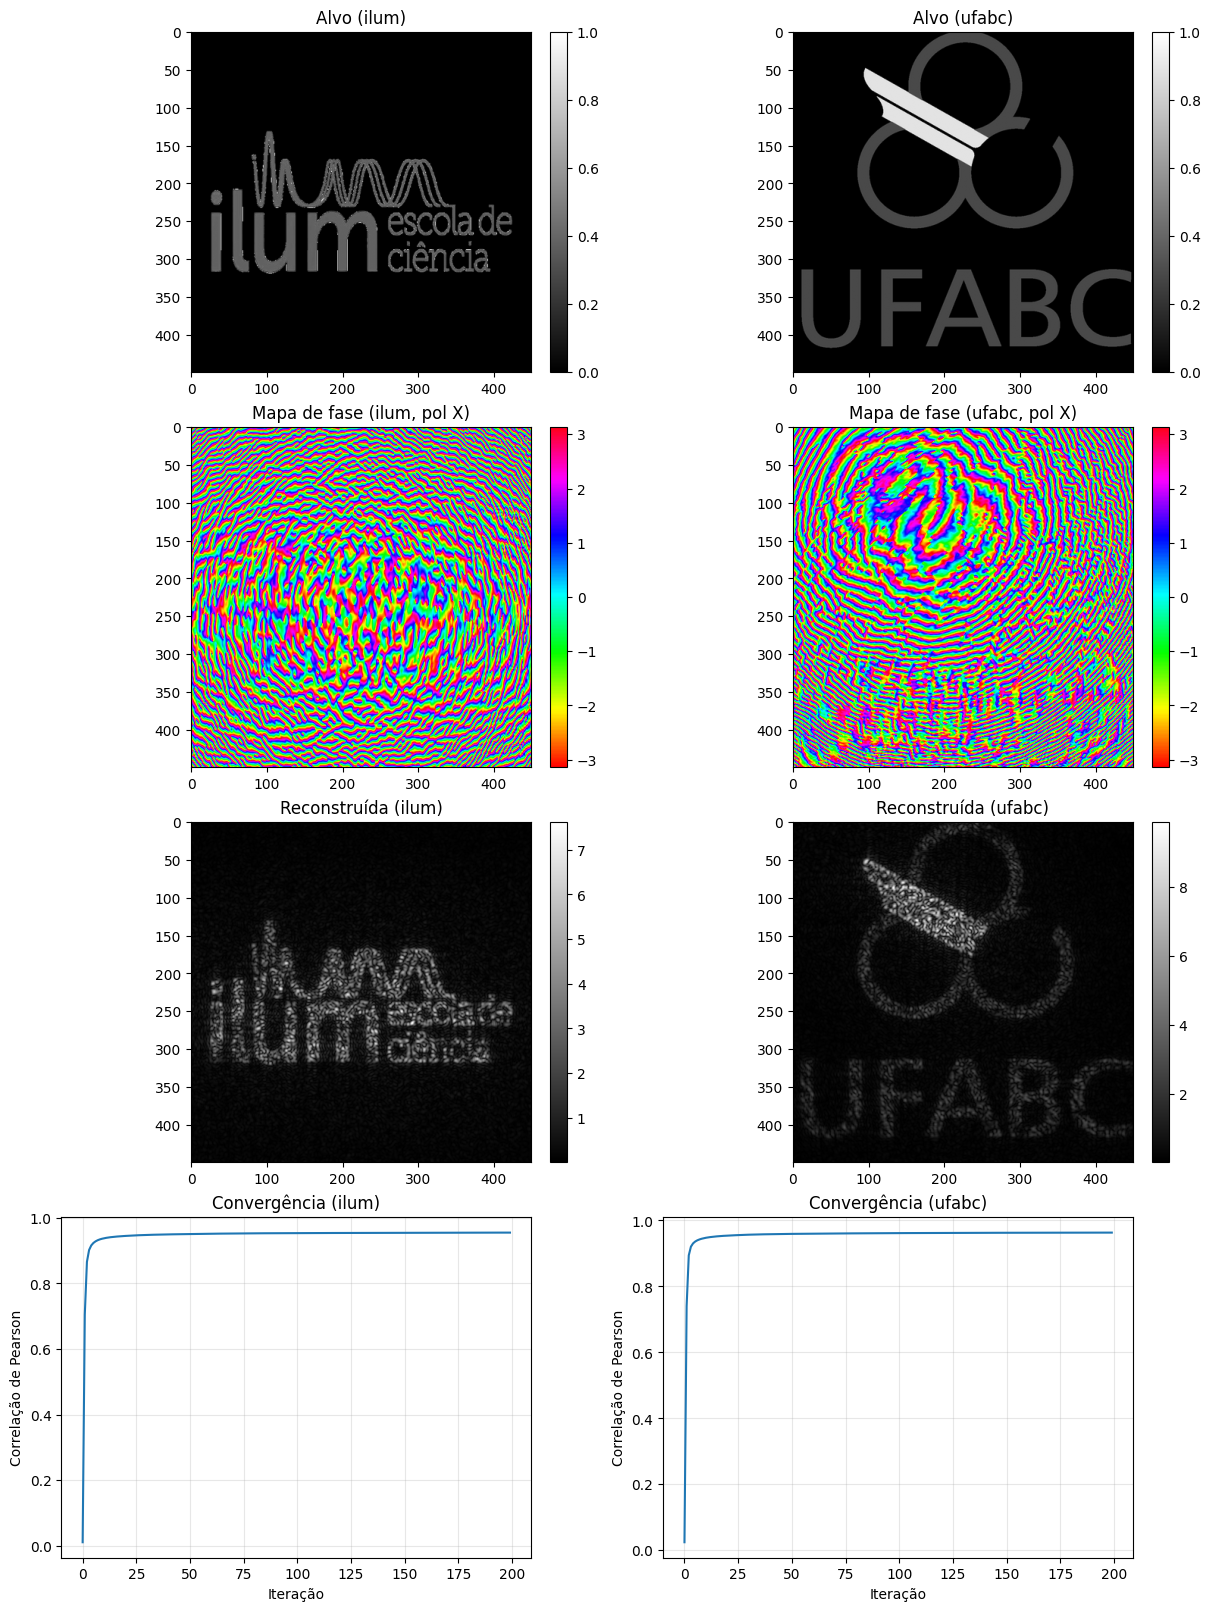

[ilum] Correlação final: 0.9551 | Salvo em: c:\Users\vinicius23011\MATLAB\Projects\TCC\results\holography\gs_x\demo_ilum_ufabc\2025-11-04T10-49-36Z\ilum
[ufabc] Correlação final: 0.9631 | Salvo em: c:\Users\vinicius23011\MATLAB\Projects\TCC\results\holography\gs_x\demo_ilum_ufabc\2025-11-04T10-49-36Z\ufabc
Sumário geral salvo em: c:\Users\vinicius23011\MATLAB\Projects\TCC\results\holography\gs_x\demo_ilum_ufabc\2025-11-04T10-49-36Z\summary__demo_ilum_ufabc__ilum__ufabc__X__λ_1064nm__z_380um__dx_520nm__iter_200.png


In [14]:
# =============================================================================
# Execução GS+ASM (Polarização X) com salvamento de figuras por-alvo + sumários
# =============================================================================

from pathlib import Path
from datetime import datetime, timezone
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Descoberta robusta do diretório do repositório (funciona de qualquer cwd)
# -----------------------------------------------------------------------------
def find_repo_root(start: Path = Path.cwd()) -> Path:
    """
    EN:
        Walk upward from `start` until a `.git` directory is found; return that
        directory as the repository root. If not found, return `start` as a
        best-effort fallback.

    PT:
        Sobe a partir de `start` até encontrar uma pasta `.git`; retorna esse
        diretório como raiz do repositório. Se não encontrar, retorna `start`
        como fallback.
    """
    for parent in [start, *start.parents]:
        if (parent / ".git").exists():
            return parent
    return start  # fallback

REPO_ROOT = find_repo_root()

# -----------------------------------------------------------------------------
# Escopo do experimento (ajuste conforme seu estudo)
# -----------------------------------------------------------------------------
EXPERIMENT   = "demo_ilum_ufabc"  # ex.: "paper_replication_2025_asmX"
POL_LABEL    = "X"                # este notebook é da polarização X
TARGETS_ROOT = REPO_ROOT / "data" / "targets" / "common"
OUT_ROOT     = REPO_ROOT / "results" / "holography" / "gs_x"

# Lista de alvos (nome lógico, caminho). O loader tem fallback didático se faltar arquivo.
targets = [
    ("ilum",  TARGETS_ROOT / "ilum.png"),
    ("ufabc", TARGETS_ROOT / "ufabc.png"),
]

# -----------------------------------------------------------------------------
# Diretório da rodada -> results/holography/gs_x/<experimento>/<run_id>/
# -----------------------------------------------------------------------------
run_id  = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")
RUN_DIR = OUT_ROOT / EXPERIMENT / run_id
RUN_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------------------
# Helpers para nomes ricos que carregam os parâmetros físicos
# -----------------------------------------------------------------------------
def _nm(x_m: float) -> int:
    """EN: meters → nm; PT: metros → nm."""
    return int(round(float(x_m) * 1e9))

def _um(x_m: float) -> int:
    """EN: meters → µm; PT: metros → µm."""
    return int(round(float(x_m) * 1e6))

def rich_name(base: str, target_name: str) -> str:
    """
    EN:
        Build a descriptive filename stem including physical parameters and
        iteration count. Example:
        phase_map__ilum__X__λ_1064nm__z_380um__dx_520nm__iter_200

    PT:
        Monta um prefixo de nome descritivo incluindo parâmetros físicos e
        número de iterações. Exemplo:
        phase_map__ilum__X__λ_1064nm__z_380um__dx_520nm__iter_200
    """
    return (f"{base}__{target_name}"
            f"__{POL_LABEL}"
            f"__λ_{_nm(wavelength)}nm"
            f"__z_{_um(z)}um"
            f"__dx_{_nm(dx)}nm"
            f"__iter_{int(num_iter)}")

# -----------------------------------------------------------------------------
# Função auxiliar para salvar figuras e fechar corretamente (sem exibir)
# -----------------------------------------------------------------------------
def _save_fig(fig: plt.Figure, path: Path, dpi: int = 300) -> None:
    """
    EN:
        Save `fig` to `path` (creating parents if needed) and close the figure.
        Use when you do not want to display the figure inline.

    PT:
        Salva `fig` em `path` (criando pastas se necessário) e fecha a figura.
        Use quando não quiser exibir a figura no notebook.
    """
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)

# -----------------------------------------------------------------------------
# Pipeline completo para um alvo
# -----------------------------------------------------------------------------
def run_pipeline_for_target(name: str, path: Path, size=(450, 450)) -> dict:
    """
    EN:
        Run the full GS+ASM pipeline for a single target:
          1) load & normalize the target image
          2) run Gerchberg–Saxton iterations with Angular Spectrum propagation
          3) reconstruct to validate the phase-only hologram
          4) save per-target artifacts (arrays + individual figures + per-target summary)

        Returns a dict with arrays, metrics and output directory.

    PT:
        Executa o pipeline GS+ASM para um único alvo:
          1) carrega e normaliza a imagem alvo
          2) executa iterações de Gerchberg–Saxton com propagação por Espectro Angular
          3) reconstrói para validar o holograma de fase única
          4) salva artefatos por-alvo (arrays + figuras individuais + sumário por-alvo)

        Retorna um dicionário com arrays, métricas e diretório de saída.
    """
    tdir = RUN_DIR / name
    tdir.mkdir(parents=True, exist_ok=True)

    # 1) Carregar alvo
    print(f"[{name}] Carregando alvo: {path}")
    target_img = load_and_preprocess_image(str(path), target_size=size)

    # 2) GS+ASM
    print(f"[{name}] Executando GS+ASM…")
    phase_map, correlations = gerchberg_saxton_angular_spectrum(
        target_img, wavelength, z, dx, NA, num_iter=num_iter
    )

    # 3) Reconstrução
    print(f"[{name}] Reconstruindo…")
    recon = reconstruct_image(phase_map, wavelength, z, dx, NA)

    # Prefixos ricos
    phase_stem = rich_name("phase_map", name)
    corr_stem  = rich_name("correlations", name)
    targ_stem  = rich_name("imagem_alvo", name)
    recon_stem = rich_name("reconstruida", name)
    conv_stem  = rich_name("convergencia", name)
    mapf_stem  = rich_name("mapa_de_fase", name)

    # Arrays numéricos (TXT portável)
    np.savetxt(tdir / f"{phase_stem}.txt", phase_map)
    np.savetxt(tdir / f"{corr_stem}.txt", correlations)

    # 4) Figuras individuais — somente textos em PT
    # Imagem alvo
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    im1 = ax1.imshow(target_img, cmap="gray")
    ax1.set_title("Imagem alvo")
    fig1.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    _save_fig(fig1, tdir / f"{targ_stem}.png")

    # Mapa de fase
    fig2, ax2 = plt.subplots(figsize=(6, 6))
    im2 = ax2.imshow(phase_map, cmap="hsv")
    ax2.set_title(f"Mapa de fase (pol {POL_LABEL})")
    fig2.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    _save_fig(fig2, tdir / f"{mapf_stem}.png")

    # Imagem reconstruída
    fig3, ax3 = plt.subplots(figsize=(6, 6))
    im3 = ax3.imshow(recon, cmap="gray")
    ax3.set_title("Imagem reconstruída")
    fig3.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    _save_fig(fig3, tdir / f"{recon_stem}.png")

    # Convergência
    fig4, ax4 = plt.subplots(figsize=(7, 4))
    ax4.plot(correlations)
    ax4.set_xlabel("Iteração")
    ax4.set_ylabel("Correlação de Pearson")
    ax4.set_title("Convergência do algoritmo")
    ax4.grid(True, alpha=0.3)
    _save_fig(fig4, tdir / f"{conv_stem}.png")

    # 5) Sumário por-alvo (4 painéis)
    figS, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), constrained_layout=True)
    ax = axes[0, 0]; im = ax.imshow(target_img, cmap="gray"); ax.set_title("Imagem alvo");        figS.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax = axes[0, 1]; im = ax.imshow(phase_map, cmap="hsv");  ax.set_title(f"Mapa de fase (pol {POL_LABEL})"); figS.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax = axes[1, 0]; im = ax.imshow(recon, cmap="gray");     ax.set_title("Imagem reconstruída"); figS.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax = axes[1, 1]; ax.plot(correlations); ax.set_xlabel("Iteração"); ax.set_ylabel("Correlação de Pearson"); ax.set_title("Convergência"); ax.grid(True, alpha=0.3)

    sumario_alvo_path = tdir / f"sumario__{name}__{POL_LABEL}__λ_{_nm(wavelength)}nm__z_{_um(z)}um__dx_{_nm(dx)}nm__iter_{int(num_iter)}.png"
    _save_fig(figS, sumario_alvo_path)

    return {
        "name": name,
        "target": target_img,
        "phase": phase_map,
        "recon": recon,
        "corrs": correlations,
        "dir": tdir,
    }

# -----------------------------------------------------------------------------
# Executa para todos os alvos
# -----------------------------------------------------------------------------
results = [run_pipeline_for_target(n, p, size=(450, 450)) for (n, p) in targets]

# -----------------------------------------------------------------------------
# Sumário geral (todas as imagens em colunas) — exibido no notebook e salvo
# -----------------------------------------------------------------------------
n_cols = len(results)
figG, axes = plt.subplots(nrows=4, ncols=n_cols, figsize=(6*n_cols, 16), constrained_layout=True)

# Normaliza indexação se houver 1 coluna
if n_cols == 1:
    axes = np.array(axes).reshape(4, 1)

for col, res in enumerate(results):
    name, tgt, phase, recon, corrs = res["name"], res["target"], res["phase"], res["recon"], res["corrs"]

    ax = axes[0, col]; im0 = ax.imshow(tgt, cmap="gray");  ax.set_title(f"Alvo ({name})");                     figG.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)
    ax = axes[1, col]; im1 = ax.imshow(phase, cmap="hsv"); ax.set_title(f"Mapa de fase ({name}, pol {POL_LABEL})"); figG.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
    ax = axes[2, col]; im2 = ax.imshow(recon, cmap="gray"); ax.set_title(f"Reconstruída ({name})");             figG.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

    ax = axes[3, col]
    ax.plot(corrs)
    ax.set_xlabel("Iteração")
    ax.set_ylabel("Correlação de Pearson")
    ax.set_title(f"Convergência ({name})")
    ax.grid(True, alpha=0.3)

# *** Exibe no notebook ***
plt.show()

# *** Salva no disco ***
summary_name = rich_name(f"summary__{EXPERIMENT}", "__".join([n for n, _ in targets]))
summary_path = RUN_DIR / f"{summary_name}.png"
figG.savefig(summary_path, dpi=300, bbox_inches="tight")
plt.close(figG)

# -----------------------------------------------------------------------------
# Log final
# -----------------------------------------------------------------------------
for r in results:
    final_corr = float(r["corrs"][-1]) if len(r["corrs"]) else float('nan')
    print(f"[{r['name']}] Correlação final: {final_corr:.4f} | Salvo em: {r['dir']}")
print(f"Sumário geral salvo em: {summary_path}")
